# Third EDA - Team 19

## Is there any thing in common with complaints that are not answered by companies?

In [ ]:
%cd /Users/mmikegame/repos/DS4A/SPTime19/notebooks/

In [2]:
import seaborn as sns
import matplotlib.pyplot  as plt
import pandas as pd
import numpy as np
from datetime import datetime
from src.maps import tag_map

%matplotlib inline

## Building the ReclameAQUI (RA) dataset sample

In [3]:
def extract_days_to_resolution(review: dict):
    if "datetime" in review and "reply" in review["responses"]["final"]:
        init_dt = datetime.strptime(review["datetime"], '%Y-%m-%dT%H:%M:%SZ')
        final_ans_dt = datetime.strptime(review["responses"]["final"]["reply"][0]["datetime"], '%Y-%m-%dT%H:%M:%SZ')
        days_diff = (final_ans_dt - init_dt).days
        if days_diff < 0:
            return 0
        return days_diff
    return np.nan


def extract_days_to_first_contact(review: dict):
    if "datetime" in review and "business" in review["responses"] and len(review["responses"]["business"]) > 0:
        init_dt = datetime.strptime(review["datetime"], '%Y-%m-%dT%H:%M:%SZ')
        final_ans_dt = datetime.strptime(review["responses"]["business"][0]["datetime"], '%Y-%m-%dT%H:%M:%SZ')
        days_diff = (final_ans_dt - init_dt).days
        if days_diff < 0:
            return 0
        return days_diff
    return np.nan


def extract_seals(review: dict):
    """
    Extract seals from review dict
    :param review:
    :return:
    """
    hasSeal = lambda r: "responses" in r and "final" in r["responses"] and "seals" in r["responses"]["final"] and len(
        r["responses"]["final"]["seals"]) > 0
    seal_struct = {"service_grade": np.nan, "would_buy_again": np.nan}

    if hasSeal(review):
        for seal in review["responses"]["final"]["seals"]:
            if seal["seal"] == "Nota do atendimento":
                seal_struct["service_grade"] = int(seal["value"])
            elif seal["seal"] == "Voltaria a fazer negócio?":
                seal_struct["would_buy_again"] = False if seal["value"] == "Não" else True

    return seal_struct

def extract_first_response(review):
    if "business" in review["responses"] and len(review["responses"]["business"]) > 0:
        len_comment = len(review['responses']['business'][0]['content'])
        return len_comment
    return np.nan

def format_RA_to_df(review):
    """
    Format scrapped review dict into a pandas friendly data structure
    :param review:
    :return:
    """
    cols_for_df = ['title', 'description', 'business_name', 'uf', 'city', 'review_ID', 'datetime', 'timeCaptured']
    r_cp = {col: review[col] for col in cols_for_df if col in review}

    r_cp["len_business_response"] = extract_first_response(review)
    r_cp["days_to_resolution"] = extract_days_to_resolution(review)
    r_cp["days_to_first_contact"] = extract_days_to_first_contact(review)
    r_cp["resolution_outcome"] = review["responses"]["final"]["result"] if "responses" in review and "final" in review[
        "responses"] and "result" in review["responses"]["final"] else np.nan

    # Extract seals and add to dict
    seals = extract_seals(review)
    for seal_name, seal_value in seals.items():
        r_cp[seal_name] = seal_value

    # Add macro-tags
    macro_tags = tag_map.keys()
    for t in macro_tags:
        if isinstance(tag_map[t], dict):
            for sub_t in tag_map[t].keys():
                r_cp[f"{t}_{sub_t}"] = np.nan
        else:
            r_cp[t] = np.nan

    # Count macro tags for complaint
    if "tags" in review:
        for tag in review["tags"]:
            
            for macro, vals in tag_map.items():
                if isinstance(tag_map[macro], dict):
                    
                    for sub_t in tag_map[macro].keys():
                        
                        tag_name = f"{macro}_{sub_t}"
                        
                        if tag in tag_map[macro][sub_t]:
                            if isinstance(r_cp[tag_name], type(np.nan)):
                                r_cp[tag_name] = 1
                            else:
                                r_cp[tag_name] += 1
                else:
                    # Others type -> list
                    if tag in vals:
                        if isinstance(r_cp[macro], type(np.nan)):
                            r_cp[macro] = 1
                        else:
                            r_cp[macro] += 1

    # Add MACRO-macro-tags
    macro_tags_2 = tag_map.keys()
    for t in macro_tags_2:
        r_cp[t] = np.nan

    # Count MACRO macro tags for complaint
    if "tags" in review:
        for tag in review["tags"]:
            for macro, vals in tag_map.items():
                if isinstance(tag_map[macro], dict):
                    for sub_t in tag_map[macro].keys():
                        tag_name = f"{macro}"
                        if tag in tag_map[macro][sub_t]:
                            if isinstance(r_cp[tag_name], type(np.nan)):
                                r_cp[tag_name] = 1
                            else:
                                r_cp[tag_name] += 1
                else:
                    # Others type -> list
                    if tag in vals:
                        if isinstance(r_cp[macro], type(np.nan)):
                            r_cp[macro] = 1
                        else:
                            r_cp[macro] += 1
                            
    # Tag response status
    if "responses" in  review and len(review["responses"]["business"]) > 0:
        r_cp["replied"] = 1
    elif "responses" in  review and len(review["responses"]["business"]) == 0:
        r_cp["replied"] = 0

    return r_cp


def build_df_from_RA(reviews: list) -> pd.DataFrame:
    return pd.DataFrame([format_RA_to_df(r) for r in reviews])

In [4]:
from util import agg_jsonls  # helper function
from pprint import pprint

# Unique reviews
unique_ids = set()
reviewsRA = []
for complaint in agg_jsonls("."):
    if "review_ID" in complaint and complaint["review_ID"] not in unique_ids:
        unique_ids.add(complaint["review_ID"])
        reviewsRA.append(complaint)
print(f"We have a total of {len(reviewsRA)} reviews!")

We have a total of 51655 reviews!


In [5]:
# Get an example of responses > 0
for review in reviewsRA:
    if "responses" in  review and len(review["responses"]["business"]) > 0:
        pprint(review)
        break

{'business_name': 'Marabraz - Lojas Físicas',
 'city': 'São Paulo',
 'datetime': '2019-10-16T17:20:00Z',
 'description': 'No dia 08/10/2019 eu e meu esposo, fomos até  a loja marabraz '
                'da Lapa (loja 014)  em busca de um armário para cozinha, '
                'vimos alguns modelos no entanto não  cabiam em nosso bolso, o '
                'vendedor até  então  muito simpático, nos mostrou alguns '
                'modelos por foto, optamos por um modelo o qual o vendedor '
                'disse ser muito bonito pessoalmente, espaçoso e resistente, '
                'no dia 10/10 recebemos o produto, na hora que fomos abrir com '
                'o montador presente para montagem, tivemos um choque, pois o '
                'produto veio na cor errada e ainda por cima é  o oposto do '
                'que o vendedor tinha nós informado, material super frágil que '
                'não  aguenta peso e feio, nos sentimos enganados,dia 12/10 '
                'fomos até 

In [6]:
# Get an example of responses == 0
for review in reviewsRA:
    if "responses" in  review and len(review["responses"]["business"]) > 0:
        pprint(review)
        break

{'business_name': 'Marabraz - Lojas Físicas',
 'city': 'São Paulo',
 'datetime': '2019-10-16T17:20:00Z',
 'description': 'No dia 08/10/2019 eu e meu esposo, fomos até  a loja marabraz '
                'da Lapa (loja 014)  em busca de um armário para cozinha, '
                'vimos alguns modelos no entanto não  cabiam em nosso bolso, o '
                'vendedor até  então  muito simpático, nos mostrou alguns '
                'modelos por foto, optamos por um modelo o qual o vendedor '
                'disse ser muito bonito pessoalmente, espaçoso e resistente, '
                'no dia 10/10 recebemos o produto, na hora que fomos abrir com '
                'o montador presente para montagem, tivemos um choque, pois o '
                'produto veio na cor errada e ainda por cima é  o oposto do '
                'que o vendedor tinha nós informado, material super frágil que '
                'não  aguenta peso e feio, nos sentimos enganados,dia 12/10 '
                'fomos até 

In [7]:
"""from src.loading import load_dataset
#from cleaning import build_df_from_RA

#reviewsRA = load_dataset("/dataset")
dff = build_df_from_RA(reviewsRA)
print(f"We have a total of {len(reviewsRA)} reviews!")"""

'from src.loading import load_dataset\n#from cleaning import build_df_from_RA\n\n#reviewsRA = load_dataset("/dataset")\ndff = build_df_from_RA(reviewsRA)\nprint(f"We have a total of {len(reviewsRA)} reviews!")'

In [8]:
df = pd.DataFrame([format_RA_to_df(row) for row in reviewsRA])
df.head()

,title,description,business_name,uf,city,review_ID,datetime,timeCaptured,len_business_response,days_to_resolution,...,product_issues_Missing pieces,business_issues_Payment,business_issues_Maintenance,business_issues_Customer Services,business_issues_Delivery,business_issues_Online Services,products,product_issues,business_issues,replied
0,Marabraz nunca mais,"No dia 08/10/2019 eu e meu esposo, fomos até ...",Marabraz - Lojas Físicas,SP,São Paulo,96147549,2019-10-16T17:20:00Z,2020-04-01T00:20:30Z,308.0,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,2.0,NaN,1.0,1
1,Barulho no braço,Comprei cj. Estofado desde que montei o braço ...,Marabraz - Lojas Físicas,SP,Caieiras,95945577,2019-10-10T08:44:00Z,2020-04-01T00:20:44Z,245.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,NaN,1
2,comprei uma box bau casal e nao tem disponivel...,comprei pessoalmente no dia 01/10 e ontem ao q...,Marabraz - Lojas Físicas,SP,São Paulo,95952915,2019-10-10T11:30:00Z,2020-04-01T00:20:44Z,357.0,5.0,...,NaN,1.0,NaN,NaN,NaN,NaN,2.0,NaN,1.0,1
3,Descaso,Desde sexta feira 11/10 aguardando a confirmaç...,Marabraz - Lojas Físicas,SP,São Bernardo do Campo,96046799,2019-10-14T11:21:00Z,2020-04-01T00:20:44Z,526.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1
4,PÉSSIMO ATENDIMENTO,ENTREI EM CONTATO COM DIVERSOS CANAIS DE RECLA...,Marabraz - Lojas Físicas,SP,Barueri,96108815,2019-10-15T18:07:00Z,2020-04-01T00:20:44Z,383.0,23.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


## Count of Reviews with and without responses

In [9]:
number_total_reviews = len(reviewsRA)
number_reviews_with_response = df['replied'][(df['replied'] == 1)].value_counts().tolist()[0]
number_reviews_with_no_response = df['replied'][(df['replied'] == 0)].value_counts().tolist()[0] #number_total_reviews - number_reviews_with_response

print(f"Total of reviews with response {number_reviews_with_response} [{round((number_reviews_with_response/number_total_reviews)*100, 2)}%]")
print(f"Total of reviews with NO response {number_reviews_with_no_response} [{round((number_reviews_with_no_response/number_total_reviews)*100, 2)}%]")
print(f"We have a total of {number_total_reviews} reviews!")

Total of reviews with response 43170 [83.57%]
Total of reviews with NO response 8485 [16.43%]
We have a total of 51655 reviews!


In [10]:
df[(df['replied'] == 0)].head()

,title,description,business_name,uf,city,review_ID,datetime,timeCaptured,len_business_response,days_to_resolution,...,product_issues_Missing pieces,business_issues_Payment,business_issues_Maintenance,business_issues_Customer Services,business_issues_Delivery,business_issues_Online Services,products,product_issues,business_issues,replied
87,produto não entregue,Comprei uma mercadoria na loja virtual da Mara...,Marabraz - Loja Online,SP,São Paulo,101188093,2020-03-04T15:28:00Z,2020-04-01T00:12:34Z,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,NaN,1.0,NaN,2.0,0
90,Lojas Marabraz entrega em 6 dias úteis!!! Cuid...,Em 16/02 efetuei a compra de um móvel na Loja ...,Marabraz - Loja Online,RJ,Rio de Janeiro,101179737,2020-03-04T12:49:00Z,2020-04-01T00:13:13Z,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,2.0,NaN,1.0,0
102,Cancelamento e atraso na entrega,Primeiro - cancelaram nossa compra sem nos avi...,Marabraz - Loja Online,SP,São Paulo,101182897,2020-03-04T13:52:00Z,2020-04-01T00:13:30Z,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,2.0,NaN,1.0,0
103,MARABRAZ NÃO ENTREGA E NÃO RESPEITA O CLIENTE,Fiz o pedido 501069161 no dia 11/02/2020 e pag...,Marabraz - Loja Online,MG,Juiz de Fora,101183293,2020-03-04T14:00:00Z,2020-04-01T00:13:30Z,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,2.0,NaN,1.0,0
111,Prazo [Editado pelo Reclame Aqui],Comprei dois módulos de guarda roupas cujo pag...,Marabraz - Loja Online,SP,Mauá,101138259,2020-03-03T14:36:00Z,2020-04-01T00:16:09Z,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,2.0,NaN,1.0,0


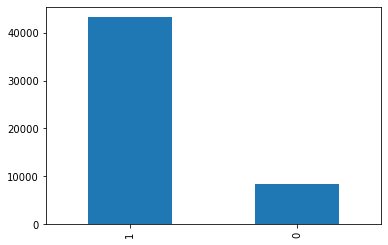

In [11]:
df.replied.value_counts().plot.bar()

## Comparative analysis: how do parameters vary according to reply status

--

In [12]:
df.replied = pd.Categorical(df.replied)
df.groupby("replied").mean()

,len_business_response,days_to_resolution,days_to_first_contact,service_grade,others,products_Home Appliances,products_Eletronics,products_Furniture,products_Accessories,products_Decoration,...,product_issues_Electrical problems,product_issues_Missing pieces,business_issues_Payment,business_issues_Maintenance,business_issues_Customer Services,business_issues_Delivery,business_issues_Online Services,products,product_issues,business_issues
replied,,,,,,,,,,,,,,,,,,,,,
0,NaN,100.480620,NaN,6.615385,2.349226,1.419795,1.441713,1.61649,1.17847,1.395833,...,1.0,1.0,1.009682,1.094017,1.081928,1.021222,1.0,1.666316,1.019345,1.041470
1,497.708872,51.032229,9.941163,6.607192,2.411289,1.482848,1.423566,1.58261,1.40116,1.213296,...,1.0,1.0,1.009763,1.173882,1.228426,1.111229,1.0,1.657962,1.044010,1.193772


In [13]:
df.groupby("days_to_resolution").resolution_outcome.count()

days_to_resolution
0.0       1046
1.0        933
2.0        841
3.0        720
4.0        663
          ... 
1833.0       1
1876.0       2
1884.0       1
1966.0       1
2025.0       1
Name: resolution_outcome, Length: 719, dtype: int64

### Percentage of unreplied complaints per store

In [14]:
df.groupby("business_name").count()

,title,description,uf,city,review_ID,datetime,timeCaptured,len_business_response,days_to_resolution,days_to_first_contact,...,product_issues_Missing pieces,business_issues_Payment,business_issues_Maintenance,business_issues_Customer Services,business_issues_Delivery,business_issues_Online Services,products,product_issues,business_issues,replied
business_name,,,,,,,,,,,,,,,,,,,,,
,547,547,544,544,547,547,547,500,208,500,...,1,11,0,10,33,1,100,14,54,547
Casas Bahia - Loja Online,3559,3559,3542,3542,3559,3559,3559,1401,211,1401,...,14,427,6,189,1181,11,2516,161,1813,3559
Casas Bahia - Lojas Físicas,3404,3404,3394,3394,3404,3404,3404,2757,533,2757,...,7,140,82,189,246,1,1491,296,657,3404
Casas Bahia - Marketplace,3854,3854,3835,3835,3854,3854,3854,3501,596,3501,...,6,388,7,103,783,3,2106,119,1283,3854
Esplanada Móveis,621,621,617,617,621,621,621,621,350,621,...,9,12,29,41,135,6,340,80,207,621
Etna Home Store,3513,3513,3497,3497,3513,3513,3513,3414,1354,3414,...,29,79,200,541,1181,102,2010,474,1764,3513
Etna Home Store - Loja Online,23,23,23,23,23,23,23,3,0,3,...,0,3,2,0,8,0,17,2,13,23
Fabrispuma,233,233,226,226,233,233,233,231,141,231,...,3,8,22,28,31,1,160,62,82,233
Fast Shop,2752,2752,2746,2746,2752,2752,2752,2703,1427,2703,...,1,469,27,409,461,13,2046,173,1378,2752


In [15]:
dff = df.groupby("business_name").count()
dff = round(dff.replied.sum()/dff.title, 2) 
pprint(dff)

business_name
                                   94.43
Casas Bahia - Loja Online          14.51
Casas Bahia - Lojas Físicas        15.17
Casas Bahia - Marketplace          13.40
Esplanada Móveis                   83.18
Etna Home Store                    14.70
Etna Home Store - Loja Online    2245.87
Fabrispuma                        221.70
Fast Shop                          18.77
Inovar Móveis e Colchões           62.16
King Star Colchões                 10.99
Lider Interiores                  146.33
Lojas Cem                         277.72
Lojas Guido                      1434.86
Lojas Lebes                        99.53
MadeiraMadeira                     13.99
Magazine Luiza - Loja Física       14.19
Magazine Luiza - Loja Online       14.40
Marabraz - Loja Online             16.70
Marabraz - Lojas Físicas           25.27
Mobly                              16.22
Móveis Rainha                     206.62
Openbox2                          698.04
Ponto Frio - Loja Online           20.70
Sy

Companies such as Esplanada Móveis, Móveis Rainha and Viggore Móveis reply 100% of the complaints. On the other hand, companies such as Casas Bahia - Loja Online, Etana Home Store - Loja Online, Lojas Cem, Lojas Guido, Magazine Luiza - Loja Online and Toka&Stok - Loja Online reply a very low percentage of their complaints on ReclameAQUI.

In [16]:
df.columns

Index(['title', 'description', 'business_name', 'uf', 'city', 'review_ID',
       'datetime', 'timeCaptured', 'len_business_response',
       'days_to_resolution', 'days_to_first_contact', 'resolution_outcome',
       'service_grade', 'would_buy_again', 'others',
       'products_Home Appliances', 'products_Eletronics', 'products_Furniture',
       'products_Accessories', 'products_Decoration', 'products_Others',
       'product_issues_Quality', 'product_issues_Damaged',
       'product_issues_Electrical problems', 'product_issues_Missing pieces',
       'business_issues_Payment', 'business_issues_Maintenance',
       'business_issues_Customer Services', 'business_issues_Delivery',
       'business_issues_Online Services', 'products', 'product_issues',
       'business_issues', 'replied'],
      dtype='object')

In [17]:
cut_off_time = pd.to_datetime(('2020-04-30 00:00:00+0000'))

df['post_age'] = (cut_off_time - pd.to_datetime(df['datetime'])).astype('timedelta64[D]')
df['post_age']

0        196.0
1        202.0
2        202.0
3        198.0
4        197.0
         ...  
51650     82.0
51651     82.0
51652     82.0
51653     82.0
51654     82.0
Name: post_age, Length: 51655, dtype: float64

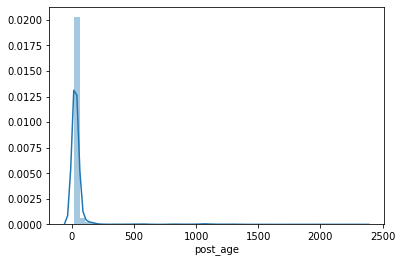

In [18]:
sns.distplot(df[df.replied == 0]['post_age']);

In [19]:
df[df.replied != 1].head()

,title,description,business_name,uf,city,review_ID,datetime,timeCaptured,len_business_response,days_to_resolution,...,business_issues_Payment,business_issues_Maintenance,business_issues_Customer Services,business_issues_Delivery,business_issues_Online Services,products,product_issues,business_issues,replied,post_age
87,produto não entregue,Comprei uma mercadoria na loja virtual da Mara...,Marabraz - Loja Online,SP,São Paulo,101188093,2020-03-04T15:28:00Z,2020-04-01T00:12:34Z,NaN,NaN,...,NaN,NaN,NaN,2.0,NaN,1.0,NaN,2.0,0,56.0
90,Lojas Marabraz entrega em 6 dias úteis!!! Cuid...,Em 16/02 efetuei a compra de um móvel na Loja ...,Marabraz - Loja Online,RJ,Rio de Janeiro,101179737,2020-03-04T12:49:00Z,2020-04-01T00:13:13Z,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,2.0,NaN,1.0,0,56.0
102,Cancelamento e atraso na entrega,Primeiro - cancelaram nossa compra sem nos avi...,Marabraz - Loja Online,SP,São Paulo,101182897,2020-03-04T13:52:00Z,2020-04-01T00:13:30Z,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,2.0,NaN,1.0,0,56.0
103,MARABRAZ NÃO ENTREGA E NÃO RESPEITA O CLIENTE,Fiz o pedido 501069161 no dia 11/02/2020 e pag...,Marabraz - Loja Online,MG,Juiz de Fora,101183293,2020-03-04T14:00:00Z,2020-04-01T00:13:30Z,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,2.0,NaN,1.0,0,56.0
111,Prazo [Editado pelo Reclame Aqui],Comprei dois módulos de guarda roupas cujo pag...,Marabraz - Loja Online,SP,Mauá,101138259,2020-03-03T14:36:00Z,2020-04-01T00:16:09Z,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,2.0,NaN,1.0,0,57.0


### When should a company have already replied to a consumer?
Let's assume a company should have only replied to a complaint if a certain amount of time has already elapsed.
In our case we have set such time to the time it usually takes the company to reply 90% of complaints

In [20]:
time_to_respond = df.groupby('business_name')['days_to_first_contact'].quantile(0.90)

companies = time_to_respond.index

In [21]:
df.post_age

0        196.0
1        202.0
2        202.0
3        198.0
4        197.0
         ...  
51650     82.0
51651     82.0
51652     82.0
51653     82.0
51654     82.0
Name: post_age, Length: 51655, dtype: float64

In [22]:
df['should_have_responded'] = 0

for index, row in df.iterrows():
    if (row['replied'] == 0) & (row['post_age'] >= time_to_respond[row.business_name]):
        df.at[index,'should_have_responded'] = 1

In [23]:
df[df.should_have_responded == 1]['post_age'].describe()

count    7841.000000
mean       53.051907
std       157.916094
min        16.000000
25%        21.000000
50%        25.000000
75%        30.000000
max      2315.000000
Name: post_age, dtype: float64

In [24]:
df.iloc[87]

title                                                              produto não entregue
description                           Comprei uma mercadoria na loja virtual da Mara...
business_name                                                    Marabraz - Loja Online
uf                                                                                   SP
city                                                                          São Paulo
review_ID                                                                     101188093
datetime                                                           2020-03-04T15:28:00Z
timeCaptured                                                       2020-04-01T00:12:34Z
len_business_response                                                               NaN
days_to_resolution                                                                  NaN
days_to_first_contact                                                               NaN
resolution_outcome              

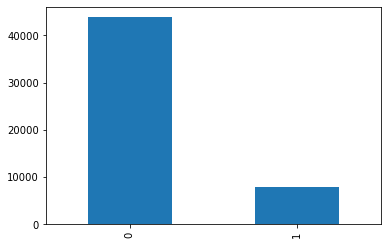

In [25]:
df.should_have_responded.value_counts().plot.bar()

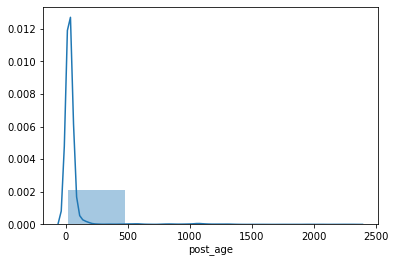

In [26]:
sns.distplot(df[df.should_have_responded == 1]['post_age'], bins = 5);

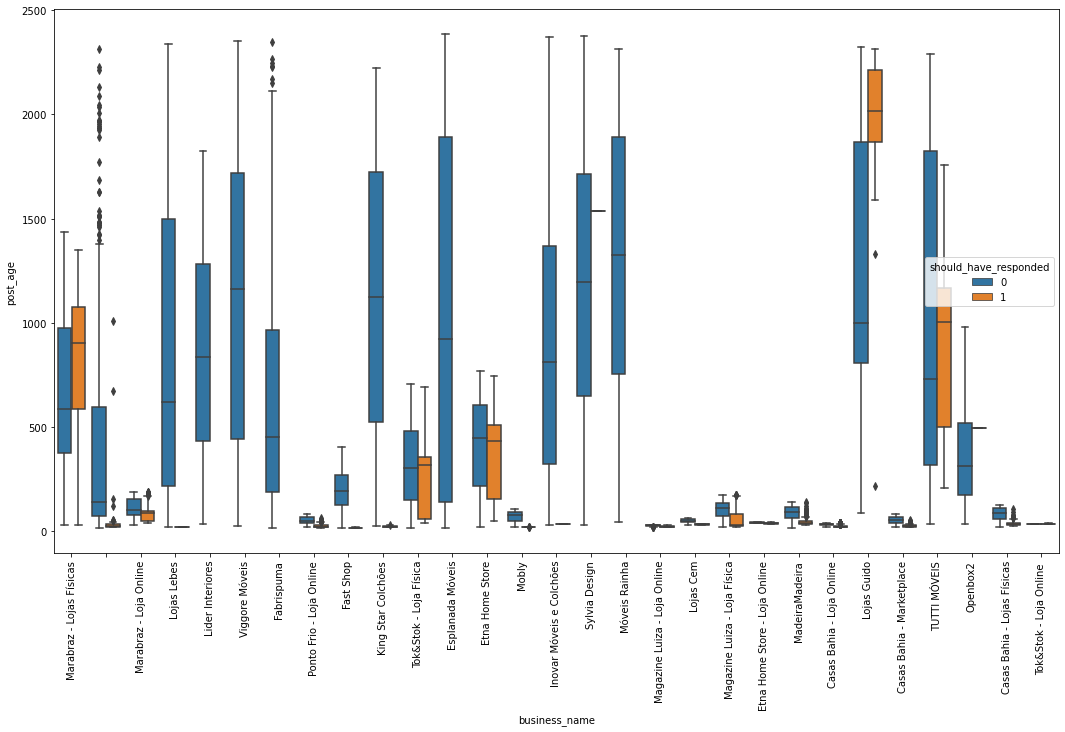

In [32]:
ax, fig = plt.subplots(figsize=(18,10))
sns.boxplot(y='post_age',x='business_name', hue='should_have_responded',data=df)
plt.xticks(rotation=90); 

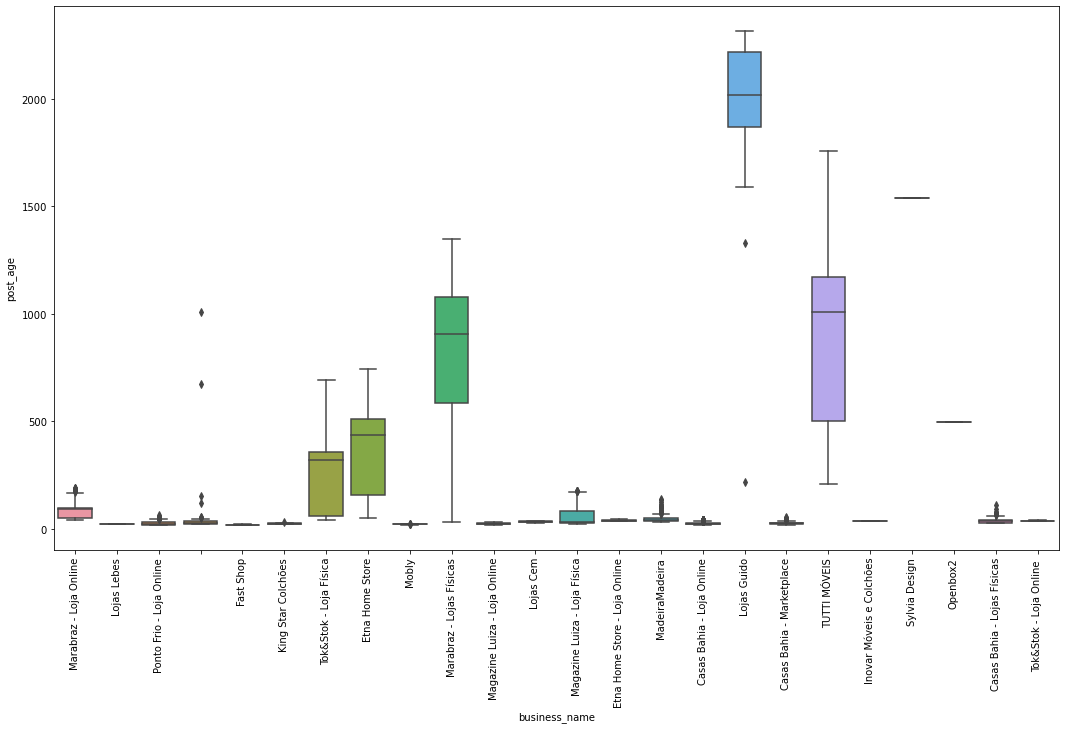

In [28]:
ax, fig = plt.subplots(figsize=(18,10))
sns.boxplot(y='post_age',x='business_name',data=df[df.should_have_responded == 1])
plt.xticks(rotation=90);

In [29]:
index = [0, 1]

temp_df = pd.DataFrame({'replied': replied,
                   'should_have_responded': should_have_responded}, index=index)
ax = temp_df.plot.bar(rot=0)

NameError: name 'replied' is not defined

In [ ]:
np.where(row.post_age > time_to_respond[company], 1, 0)

In [ ]:
df.loc[df.business_name == 'Tok&Stok - Loja Online']

In [ ]:
df['datetime'] = pd.to_datetime(df.datetime)
df['month'] = df['datetime'].dt.strftime('%m/%Y')

In [ ]:
agg = df.groupby(['business_name','month']).agg({'business_issues':['sum', 'count'],
                                                      'product_issues':['sum', 'count'],
                                                      'datetime':'max'})

In [ ]:
df_agg = pd.DataFrame(agg.to_records())
df_agg.columns = ['business_name','date','business_issues', 'business_issues_count', 
                    'product_issues', 'product_issues_count','datetime'] 

In [ ]:
fig = plt.figure(figsize=(12,180))
w=1
for j in df_agg['business_name'].unique():
    for i in ['business_issues', 'product_issues']:
        plt.subplot(29,2,w)
        plt.plot('date', i,data=df_agg[df_agg['business_name']==j].sort_values(by='datetime'),
                 marker='.')
        plt.title(i+' - '+j);
        w=w+1

## Count of complaints with no response

In [ ]:
reviews_with_response = [review for review in reviewsRA if "responses" in  review and len(review["responses"]["business"]) > 0]
reviews_with_no_response = [review for review in reviewsRA if "responses" in  review and len(review["responses"]["business"]) == 0]

print(f"Total of reviews with response {len(reviews_with_response)} [{round((len(reviews_with_response)/len(reviewsRA))*100, 2)}%]")
print(f"Total of reviews with NO response {len(reviews_with_no_response)} [{100- round((len(reviews_with_response)/len(reviewsRA))*100, 2)}%]")
print(f"We have a total of {len(reviewsRA)} reviews!")

In [ ]:
# Pre-load tag columns
product_issues_columns = ['product_issues_Quality','product_issues_Damaged', 'product_issues_Electrical problems','product_issues_Missing pieces']
business_issues_columns = ['business_issues_Payment','business_issues_Maintenance', 'business_issues_Customer Services','business_issues_Delivery', 'business_issues_Online Services']
tag_columns = product_issues_columns.copy()
tag_columns.extend(business_issues_columns)

# Create product/business issue tag and drop those who have both tagged to simplify our analysis
df_tag = df[tag_columns].fillna(0).applymap(lambda x: 1 if x>0 else 0)
df_tag["product_issue"] = df_tag[product_issues_columns].max(axis=1)
df_tag["business_issue"] = df_tag[business_issues_columns].max(axis=1)
df_tag = df_tag[df_tag[["product_issue", "business_issue"]].sum(axis=1) != 2]
df_tag = df_tag[df_tag[["product_issue", "business_issue"]].sum(axis=1) != 0]

df_tag = df_tag.loc[df_tag.index.intersection(feat_df.index)] # match index from feature df 
df_tag.head()

In [ ]:
print(df.business_name.unique())

**Correlation between average response time and whether or not a response was positive/negative.**

We lack more data where we have a "negative" resolution, but for those cases where we have a resolution we see that on average that takes one or two days to close.
We might dig deeper to understand what features these kind of complaints have in common.

In [ ]:
dff.resolution_outcome = pd.Categorical(dff.resolution_outcome)
dff.groupby("resolution_outcome").mean()

**Average time to company response and evaluating experience.**

On average, companies take 3 days to give the first reply. Also, when aggregating by days before contact, we have a hint that positive responses appear more frequently when the contact is made ealier on.

In [ ]:
dff.describe()

In [ ]:
dff.groupby("days_to_first_contact").resolution_outcome.count()

In [ ]:
answered_perc = round(dff.days_to_first_contact.count()/dff.shape[0] * 100, 2) 
print(f"Total of answered complaints : {answered_perc}%")

**Percentage of answered complaints by store**

In [ ]:
aa = dff.groupby("business_name").count()
aa = round(aa.days_to_first_contact/aa.review_ID * 100, 2) 
pprint(aa)

**Investigation of ' ' stores**

We see that it must been some sort of bug while scraping data from RA. We have descriptions pointing towards different stores, so it is not a single store problem.

In [ ]:
dff.loc[dff["business_name"]=='']

**Tag analysis**

In [ ]:
unique_tags = set()
for review in reviewsRA:
    if "tags" in review:
        for tag in review["tags"]:
            unique_tags.add(tag)

print(f"We have {len(unique_tags)} unique tags!")
pprint(unique_tags)

**What categories of complaints correlate to poor evaluations?**

In [ ]:
unique_tags = set()
unique_businesses = set()

for review in reviewsRA:
    if "business_name" in review:
        unique_businesses.add(review['business_name'])
        if "tags" in review:
            for tag in review["tags"]:
                unique_tags.add(tag)

for review in reviewsRA:
    if "tag" in review:
        for tag in review["tags"]:
            unique_tags.add(tag)

print(f"We have {len(unique_businesses)} businesses.")
pprint(unique_businesses)
            
print(f"We have {len(unique_tags)} unique tags.")
pprint(unique_tags)

In [ ]:
tags_per_businesses = pd.DataFrame(0, columns = unique_businesses, index = unique_tags)

tags_per_businesses['Mobly']['Eletroportáteis'] += 1

tags_per_businesses.head()

In [ ]:
for review in reviewsRA:
    if "tags" in review:
        for tag in review['tags']:
#            print(review['business_name'])
#            print(tag)
            tags_per_businesses[review['business_name']][tag] += 1 
    
tags_per_businesses

In [ ]:
formatted_rows = []

for review in reviewsRA:
    if "business_name" in review and "responses" in review:
        panda_row = {"business_name": review["business_name"]}
        
        if len(review["responses"]["business"]) > 0:
            panda_row["has_reply"] = True
        else:
            panda_row["has_reply"] = False
            
        if "result" in review["responses"]["final"]:
            panda_row["reply_outcome"] = "positive"
        else:
            panda_row["reply_outcome"] = "negative"
        
        panda_row["tags"] = "_".join(review["tags"])
        
        formatted_rows.append(panda_row)

df = pd.DataFrame(formatted_rows)
df.head()

## NLP Analysis

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd
import nltk 
from nltk.corpus import stopwords
#nltk.download('punkt')
#nltk.download('stopwords')
import numpy  as np
import string
#from nltk.stem import PorterStemmer 
import unicodedata

In [ ]:
word_cloud_text = ' '.join(dff['description'])

stop_words = set(stopwords.words("portuguese"))
without_stop_words = []
sentence = word_cloud_text
words = nltk.word_tokenize(sentence)
for word in words:
    if word not in stop_words:
        without_stop_words.append(word)

In [ ]:
stop_words = set(stopwords.words("portuguese"))
without_stop_words = []
stopword = []
sentence = word_cloud_text
words = nltk.word_tokenize(sentence)
for word in words:
    if word in stop_words:
        stopword.append(word)
    else:
        without_stop_words.append(word)

In [ ]:
def clean_reviews(review):
    without_stop_words = []
    words = nltk.word_tokenize(review.lower())
    for word in words:
        if not word in stop_words:
            without_stop_words.append(word)

    return ' '.join(without_stop_words)

In [ ]:
def strip_punctuation(text):
    """
    >>> strip_punctuation(u'something')
    u'something'

    >>> strip_punctuation(u'something.,:else really')
    u'somethingelse really'
    """
    punctutation_cats = set(['Pc', 'Pd', 'Ps', 'Pe', 'Pi', 'Pf', 'Po'])
    return ''.join(x for x in text
                   if unicodedata.category(x) not in punctutation_cats)

In [ ]:
dff['cleaned_review'] = dff.description.apply(lambda x: strip_punctuation(clean_reviews(x)))
    
dff.head()

In [ ]:
from collections import Counter

AllReviews = dff['cleaned_review']

all_reviews_text = ' '.join(AllReviews)
tokenized_words = nltk.word_tokenize(all_reviews_text)
word_freq = Counter(tokenized_words)

word_freq.most_common(20)

In [ ]:
selected_reviews = [each for each in AllReviews if 'entrega' in each]

for review in selected_reviews[:30]:
    index = review.find('entrega')
    print(review[index-10:index+20].replace("\n", ""))

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_words(corpus, n=1,k=1):
    vec = CountVectorizer(ngram_range=(k,k),stop_words = 'portuguese').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [ ]:
from nltk.util import ngrams

def top_k_ngrams(word_tokens,n,k):
    
    n_gram_list = list(ngrams(word_tokens, n))

    n_gram_strings = [' '.join(each) for each in n_gram_list]
    
    n_gram_counter = Counter(n_gram_strings)
    most_common_k = n_gram_counter.most_common(k)
    pprint(most_common_k)

In [ ]:
port_stopwords = stopwords.words('portuguese')

#n-grams
word_tokens = nltk.word_tokenize(all_reviews_text)
top_k_ngrams(word_tokens, 3, 10)

In [ ]:
top_k_ngrams(word_tokens, 2, 10)

In [ ]:
def get_top_n_words(corpus, n=1,k=1):
    vec = CountVectorizer(ngram_range=(k,k),stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [ ]:
common_words = get_top_n_words(AllReviews, 20, 2)

for word, freq in common_words:
    print(word, freq)

df = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])

In [ ]:
#Inovar vs. Sylvia Design

inovar_reviews = [each for each in dff[dff.business_name == 'Inovar Móveis e Colchões'].cleaned_review]

sylvia_reviews = [each for each in dff[dff.business_name == 'Sylvia Design'].cleaned_review]

In [ ]:
inovar_reviews_text = ' '.join(inovar_reviews)
tokenized_words = nltk.word_tokenize(inovar_reviews_text)
inovar_word_freq = Counter(tokenized_words)

inovar_word_freq.most_common(20)

In [ ]:
sylvia_reviews_text = ' '.join(sylvia_reviews)
tokenized_words = nltk.word_tokenize(sylvia_reviews_text)
sylvia_word_freq = Counter(tokenized_words)

sylvia_word_freq.most_common(20)

In [ ]:
inovar_word_tokens = nltk.word_tokenize(inovar_reviews_text)
top_k_ngrams(inovar_word_tokens, 4, 10)

In [ ]:
sylvia_word_tokens = nltk.word_tokenize(sylvia_reviews_text)
top_k_ngrams(sylvia_word_tokens, 4, 10)

### General impressions
In general, an NLP analysis of the dataset shows that most complaints made against furniture retailers revolve around words related to the order (order, shop, buy, store) or to the actual delivery of the product (day, delivery, days, arrival). A k-gram investigation of the issue confirms our findings and word sets such as "5 working days" and "delivery date" are on top of the list.
We then proceeded to a side-by-side comparison between 2 similar sized businesses: Sylvia Design and Inovar. A word frequency analysis shows us that both experience most customer inquires regarding couches, however, their approaches to delivering their mecharndise differ somewhat. Sylvia Design delivers in 45 to 60 days while Inovar's delivery is 15 days shorter.